# **Plant Disease Classification with a Sequential CNN**

This notebook provides an end-to-end workflow for identifying plant diseases from leaf imagery. It is structured to allow both high-level overviews and in-depth exploration of the implementation.

### **Project Overview**
- **Objective**: Train a Convolutional Neural Network (CNN) to classify 38 plant disease categories.
- **Dataset**: PlantVillage color image dataset containing labeled plant leaf images.
- **Libraries**: 
  - **TensorFlow/Keras** for deep learning and model building
  - **PIL & NumPy** for image preprocessing and handling
  - **Matplotlib** for visualization and results plotting
- **Workflow**: 
  1. Explore and preprocess the dataset
  2. Configure data generators with augmentation
  3. Build and train a custom CNN model
  4. Monitor model performance during training
  5. Evaluate the model and save it for future inference


In [1]:
import os
import json
from PIL import Image
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error
import seaborn as sns


### **Setting Random Seeds**

Setting random seeds ensures reproducibility of results across different runs.


In [2]:
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

### **Dataset Configuration**

Define the path to the PlantVillage color dataset directory.


In [3]:
dataset_dir = "plantvillage dataset/color"

### **Dataset Exploration**

Explore the dataset structure, count images per class, and examine image dimensions.


In [4]:
import os
from PIL import Image

# List all categories (classes)
categories = os.listdir(dataset_dir)

# Initialize statistics
num_classes = len(categories)
total_images = 0
class_image_counts = {}

# Prepare data for the table
table_data = []

# Count images in each class and get image shape
for category in categories:
    category_path = os.path.join(dataset_dir, category)
    image_files = os.listdir(category_path)
    num_images_in_category = len(image_files)

    class_image_counts[category] = num_images_in_category
    total_images += num_images_in_category

    # Add data to the table list
    table_data.append([category, num_images_in_category])

# Print the table header with more spacing
print(f"{'Class Name':<45} {'Number of Images':<20}")
print("-" * 70)

# Print the rows of the table with additional space
for row in table_data:
    print(f"{row[0]:<55} {row[1]:<20}")

# Print overall dataset statistics
print(f"\nTotal number of classes: {num_classes}")
print(f"Total number of images: {total_images}")


Class Name                                    Number of Images    
----------------------------------------------------------------------
Apple___Apple_scab                                      630                 
Apple___Black_rot                                       621                 
Apple___Cedar_apple_rust                                275                 
Apple___healthy                                         1645                
Blueberry___healthy                                     1502                
Cherry_(including_sour)___healthy                       854                 
Cherry_(including_sour)___Powdery_mildew                1052                
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot      513                 
Corn_(maize)___Common_rust_                             1192                
Corn_(maize)___healthy                                  1162                
Corn_(maize)___Northern_Leaf_Blight                     985                 
Grape___Black_r

### **Visualizing Sample Images**

Display one random image from each disease category to get a visual overview of the dataset.


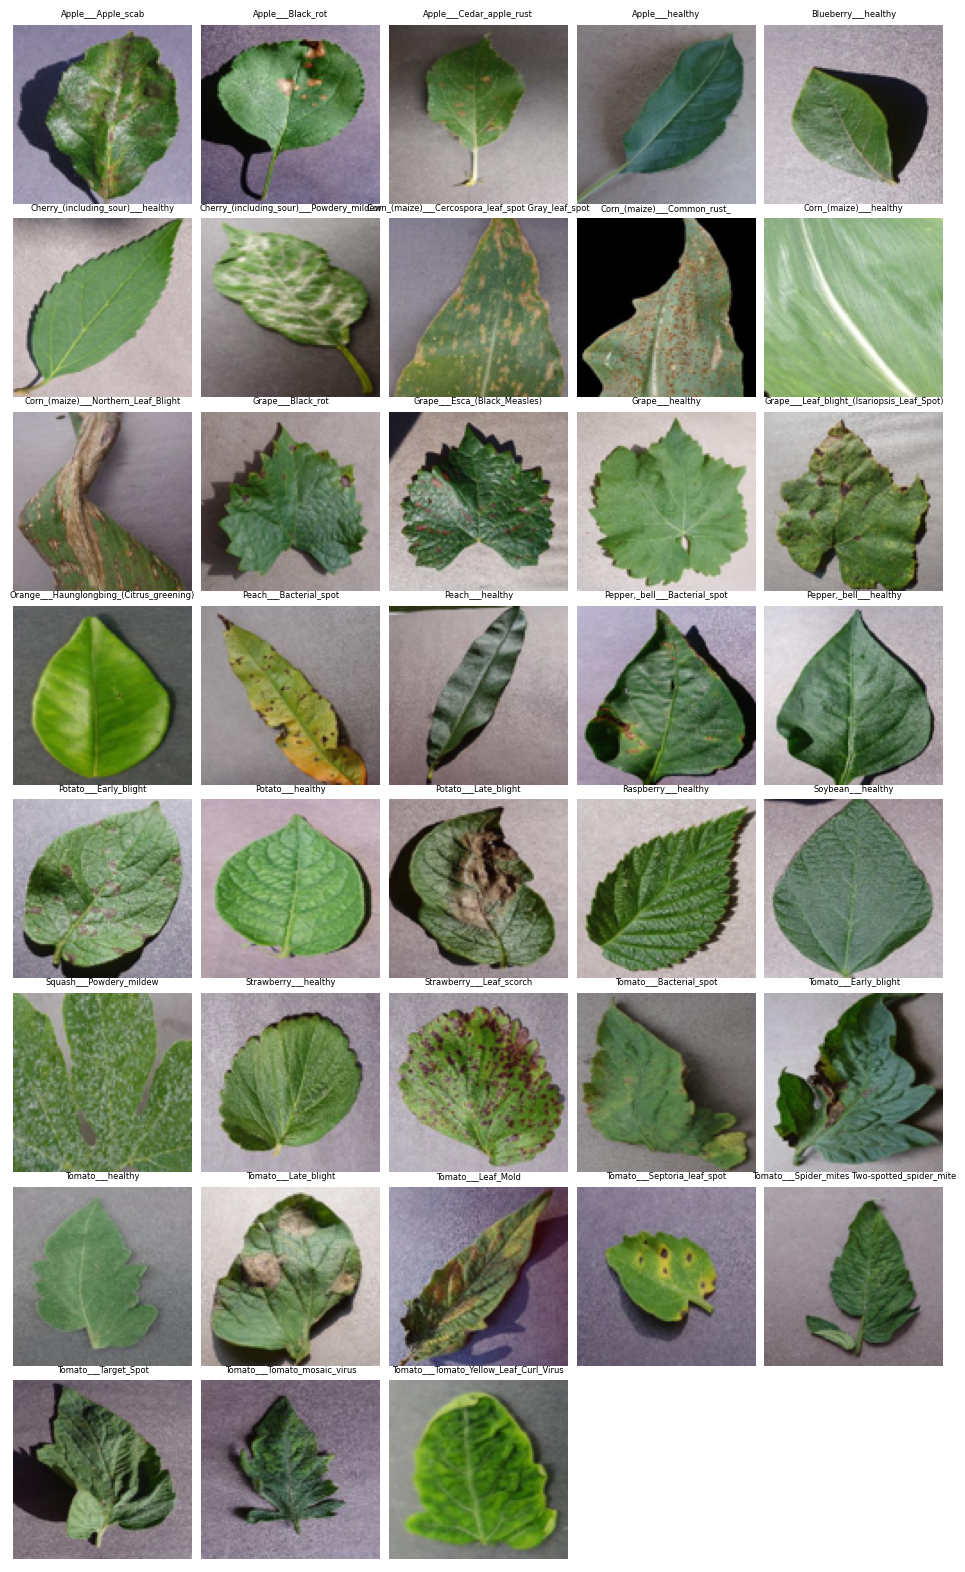

In [5]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Set up the plot grid (5 images per row)
num_images_per_row = 5
num_rows = (len(categories) + num_images_per_row - 1) // num_images_per_row  # Calculate the number of rows needed

# Adjust figure size and reduce spaces between images
fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=(12, num_rows * 2.5), facecolor='none')  # Set transparent background for the figure
axes = axes.flatten()  # Flatten to easily iterate over the grid

# Display one random image per category
for i, category in enumerate(categories):
    category_path = os.path.join(dataset_dir, category)
    image_files = os.listdir(category_path)
    
    # Randomly pick an image
    random_image = random.choice(image_files)
    img_path = os.path.join(category_path, random_image)
    img = Image.open(img_path)
    
    # Resize the image to be smaller (adjust the size as needed)
    img = img.resize((100, 100))  # Resize to 100x100 pixels
    
    # Plot the image
    axes[i].imshow(img)
    axes[i].axis('off')  # Remove axis for clarity
    axes[i].set_title(category, fontsize=6)  # Smaller font size for titles

# Hide any empty subplots if there are fewer than `num_images_per_row` categories
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout to remove extra spaces between images and titles
plt.subplots_adjust(wspace=0.05, hspace=0.05)  # Reduce space between images

# Show the plot with transparent background
plt.show()


### **Image Preprocessing Test**

Test loading and displaying a sample image to verify image preprocessing pipeline.


In [6]:
# Example: Load and display a sample image from the dataset
# Replace with an actual image path from your dataset
sample_category = categories[0] if categories else None
if sample_category:
    category_path = os.path.join(dataset_dir, sample_category)
    image_files = os.listdir(category_path)
    if image_files:
        sample_image_path = os.path.join(category_path, image_files[0])
        img = mpimg.imread(sample_image_path)
        print(f"Image shape: {img.shape}")
        print(f"Image dtype: {img.dtype}")
        print(f"Image min/max values: {img.min()}/{img.max()}")

Image shape: (256, 256, 3)
Image dtype: uint8
Image min/max values: 0/226


### **Model Hyperparameters**

Define key hyperparameters for image preprocessing and training:
- **Image Size**: Target dimensions for resizing images (224x224 is standard for CNNs)
- **Batch Size**: Number of samples processed before updating model weights


In [7]:
# Image Parameters
img_size = 224
batch_size = 16

### **Data Augmentation and Preprocessing**

Configure the ImageDataGenerator with:
- **Rescaling**: Normalize pixel values to [0, 1] range
- **Validation Split**: Reserve 20% of data for validation


In [8]:
# Image Data Generators
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Use 20% of data for validation
)

### **Training Data Generator**

Create a generator for training data that:
- Loads images from the dataset directory
- Resizes images to the target size
- Splits data into training subset (80%)
- Provides categorical labels for multi-class classification


In [9]:
# Train Generator
train_generator = data_gen.flow_from_directory(
    dataset_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical'
)

Found 43456 images belonging to 38 classes.


### **Validation Data Generator**

Create a generator for validation data that:
- Uses the same preprocessing as training data
- Splits data into validation subset (20%)
- Used for monitoring model performance during training


In [10]:
# Validation Generator
validation_generator = data_gen.flow_from_directory(
    dataset_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical'
)

Found 10849 images belonging to 38 classes.


### **Building the CNN Model**

Construct a custom Convolutional Neural Network with:
- **4 Convolutional Blocks**: Progressive feature extraction (32 → 64 → 128 → 128 filters)
- **Batch Normalization**: Stabilizes training and accelerates convergence
- **Max Pooling**: Reduces spatial dimensions and computational complexity
- **Global Average Pooling**: Reduces overfitting and parameter count
- **Dense Layers**: Fully connected layers with dropout for regularization
- **Softmax Output**: Multi-class classification layer


In [ ]:
# Define the model
model = models.Sequential()

# First Convolutional Block
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
model.add(layers.BatchNormalization())  # Batch normalization
model.add(layers.MaxPooling2D(2, 2))

# Second Convolutional Block
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())  # Batch normalization
model.add(layers.MaxPooling2D(2, 2))

# Third Convolutional Block with 128 filters
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())  # Batch normalization
model.add(layers.MaxPooling2D(2, 2))

# Fourth Convolutional Block with 128 filters
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())  # Batch normalization
model.add(layers.MaxPooling2D(2, 2))

# Global Average Pooling layer to reduce overfitting and number of parameters
model.add(layers.GlobalAveragePooling2D())

# Fully Connected (Dense) Layers
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))  # Dropout to prevent overfitting

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))  # Dropout to prevent overfitting

# Output Layer
model.add(layers.Dense(train_generator.num_classes, activation='softmax'))

c:\ProgramData\miniconda3\envs\jupyter-global\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### **Model Architecture Summary**

Display the complete model architecture including layer types, output shapes, and parameter counts.


In [12]:
# model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 449,382 (1.71 MB)

 Trainable params: 448,678 (1.71 MB)

 Non-trainable params: 704 (2.75 KB)

### **Model Compilation**

Configure the model for training:
- **Optimizer**: Adam optimizer with learning rate 0.001
- **Loss Function**: Categorical cross-entropy for multi-class classification
- **Metrics**: Accuracy to track model performance


In [13]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Use Adam optimizer with a learning rate of 0.001
    loss='categorical_crossentropy',       # Categorical cross-entropy loss function
    metrics=['accuracy']                   # Track accuracy during training
)

### **Training Callbacks**

Configure callbacks to improve training:
- **Early Stopping**: Stops training if validation loss doesn't improve for 5 epochs
- **Model Checkpoint**: Saves the best model weights based on validation loss


In [14]:
# Define EarlyStopping and ModelCheckpoint callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss for early stopping
    patience=5,           # Number of epochs with no improvement after which training stops
    verbose=1,            # Display logs
    restore_best_weights=True  # Restore best weights after stopping
)

checkpoint = ModelCheckpoint(
    'best_model.h5',  # Save the best model weights
    monitor='val_loss',
    save_best_only=True,  # Save model only if validation loss improves
    verbose=1
)

### **Model Training**

Train the model for up to 10 epochs with:
- Training and validation data generators
- Early stopping and checkpoint callbacks
- Monitoring of training and validation metrics


In [15]:
# Train the model
history = model.fit(
    train_generator,            # Training data
    epochs=10,                  # Number of epochs
    validation_data=validation_generator,  # Validation data
    callbacks=[early_stopping, checkpoint],  # Callbacks during training
)

Epoch 1/10


c:\ProgramData\miniconda3\envs\jupyter-global\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2716/2716 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4813 - loss: 1.8910
Epoch 1: val_loss improved from None to 0.98288, saving model to best_model.h5


2716/2716 ━━━━━━━━━━━━━━━━━━━━ 3205s 1s/step - accuracy: 0.5967 - loss: 1.3984 - val_accuracy: 0.7046 - val_loss: 0.9829
Epoch 2/10
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7549 - loss: 0.8002
Epoch 2: val_loss did not improve from 0.98288
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 2942s 1s/step - accuracy: 0.7787 - loss: 0.7201 - val_accuracy: 0.6249 - val_loss: 1.4798
Epoch 3/10
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8393 - loss: 0.5169
Epoch 3: val_loss improved from 0.98288 to 0.41030, saving model to best_model.h5


2716/2716 ━━━━━━━━━━━━━━━━━━━━ 10520s 4s/step - accuracy: 0.8490 - loss: 0.4837 - val_accuracy: 0.8736 - val_loss: 0.4103
Epoch 4/10
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 0s 953ms/step - accuracy: 0.8835 - loss: 0.3799
Epoch 4: val_loss improved from 0.41030 to 0.20988, saving model to best_model.h5


2716/2716 ━━━━━━━━━━━━━━━━━━━━ 2694s 992ms/step - accuracy: 0.8878 - loss: 0.3652 - val_accuracy: 0.9280 - val_loss: 0.2099
Epoch 5/10
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9054 - loss: 0.3104
Epoch 5: val_loss did not improve from 0.20988
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 14350s 5s/step - accuracy: 0.9077 - loss: 0.3047 - val_accuracy: 0.8910 - val_loss: 0.3608
Epoch 6/10
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 0s 955ms/step - accuracy: 0.9185 - loss: 0.2693
Epoch 6: val_loss did not improve from 0.20988
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 2698s 993ms/step - accuracy: 0.9205 - loss: 0.2611 - val_accuracy: 0.7555 - val_loss: 1.1830
Epoch 7/10
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 0s 987ms/step - accuracy: 0.9300 - loss: 0.2306
Epoch 7: val_loss did not improve from 0.20988
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 2832s 1s/step - accuracy: 0.9321 - loss: 0.2251 - val_accuracy: 0.8591 - val_loss: 0.4902
Epoch 8/10
2716/2716 ━━━━━━━━━━━━━━━━━━━━ 0s 992ms/step - accuracy: 0.9386 - loss: 0.2077
Epoch 8: va

### **Saving the Trained Model**

Save the complete trained model to disk for future inference and deployment.


In [16]:
# Save the trained model to a file
model.save('model_2_v2.h5')


### **Model Evaluation**

Evaluate the trained model on the validation set to get:
- Validation loss
- Validation accuracy


In [18]:
import numpy as np

# Calculate the steps (make sure it's an integer)
steps = int(np.ceil(validation_generator.samples / batch_size))

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator, steps=steps, verbose=1)

# Print evaluation results
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


679/679 ━━━━━━━━━━━━━━━━━━━━ 107s 157ms/step - accuracy: 0.9280 - loss: 0.2099
Validation Loss: 0.2099
Validation Accuracy: 92.80%
